[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3572, number of used features: 2
[LightGBM] [Info] Start training from score 1949.150814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 2646.47
RMSE LightGBM: 2646.470159169033


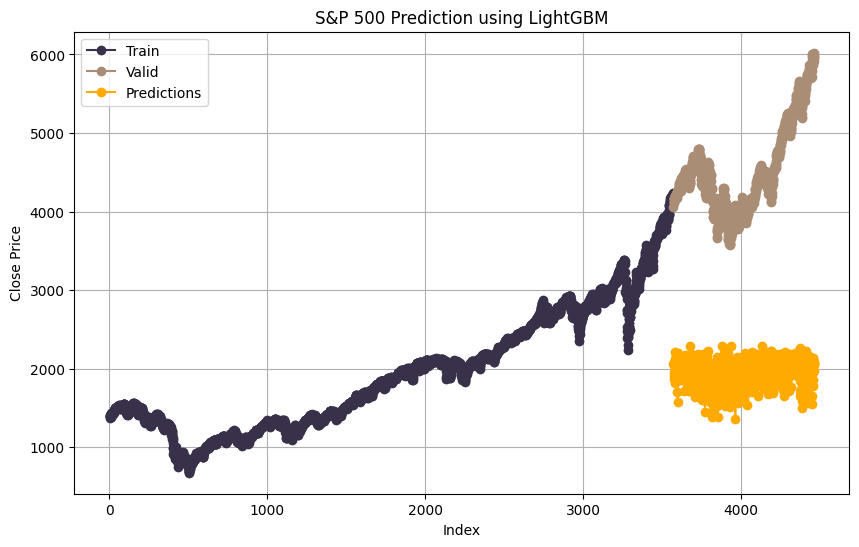

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import plotly.graph_objs as go

def prepare_data(data, h_vals):
    data['Returns'] = np.log(data['Close']).diff()  # Calculate log returns
    data.dropna(inplace=True)  # Drop missing values
    
    # Add log_h values directly to the main data without merging on x_vals
    data['log_h'] = h_vals['log_h'].values[:len(data)]
    
    return data[['Close', 'Returns', 'log_h']]

def lightgbm_model(stock_name, data, h_vals):
    # Prepare the data
    data = prepare_data(data, h_vals)
    
    # Define features and target
    X = data[['Returns', 'log_h']]
    y = data['Close']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize and train the LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.9
    }
    
    model = lgb.train(params, train_set=train_data, num_boost_round=1000, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    predictions = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    print(f'RMSE LightGBM: {rmse}')

    # Plot results using matplotlib
    train = data.iloc[:len(X_train)]
    valid = data.iloc[len(X_train):]
    
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Close'], label='Train', color='#39304A', marker='o')
    plt.plot(valid.index, valid['Close'], label='Valid', color='#A98D75', marker='o')
    plt.plot(valid.index, predictions, label='Predictions', color='#FFAA00', marker='o')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('S&P 500 Prediction using LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions, rmse

# Example usage
data = pd.read_csv('sp500.csv')
h_vals = pd.read_csv('h_vals.csv')
h_vals['log_h'] = np.log(h_vals['h_values'])
predictions, rmse = lightgbm_model('S&P 500', data, h_vals)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

def prepare_data(data, h_vals, n_lags=5):
    data['Returns'] = np.log(data['Close']).diff()  # Calculate log returns
    data.dropna(inplace=True)  # Drop missing values
    
    # Add log_h values directly to the main data without merging on x_vals
    data['log_h'] = h_vals['log_h'].values[:len(data)]
    
    # Create lagged features to help model temporal relationships
    for lag in range(1, n_lags + 1):
        data[f'Returns_Lag_{lag}'] = data['Returns'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values after lagging
    
    return data[['Close', 'Returns', 'log_h'] + [f'Returns_Lag_{lag}' for lag in range(1, n_lags + 1)]]

def lightgbm_model(stock_name, data, h_vals):
    data = prepare_data(data, h_vals)
    
    # Define features and target
    X = data.drop(columns=['Close'])
    y = data['Close']

    # Split the data into training and testing sets (keeping sequential order)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Initialize and train the LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.9
    }
    
    model = lgb.train(params, train_set=train_data, num_boost_round=1000, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    predictions = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    print(f'RMSE LightGBM: {rmse}')

    # Plot results using matplotlib
    train = data.iloc[:split_index]
    valid = data.iloc[split_index:]
    
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Close'], label='Train', color='#39304A')
    plt.plot(valid.index, valid['Close'], label='Valid', color='#A98D75')
    plt.plot(valid.index, predictions, label='Predictions', color='#FFAA00')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('S&P 500 Prediction using LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions, rmse

# Example usage
data = pd.read_csv('sp500.csv')
h_vals = pd.read_csv('h_vals.csv')
h_vals['log_h'] = np.log(h_vals['h_values'])
predictions, rmse = lightgbm_model('S&P 500', data, h_vals)


KeyboardInterrupt: 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3568, number of used features: 6
[LightGBM] [Info] Start training from score 0.000297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0104975
RMSE LightGBM (Returns): 0.010497521991510913


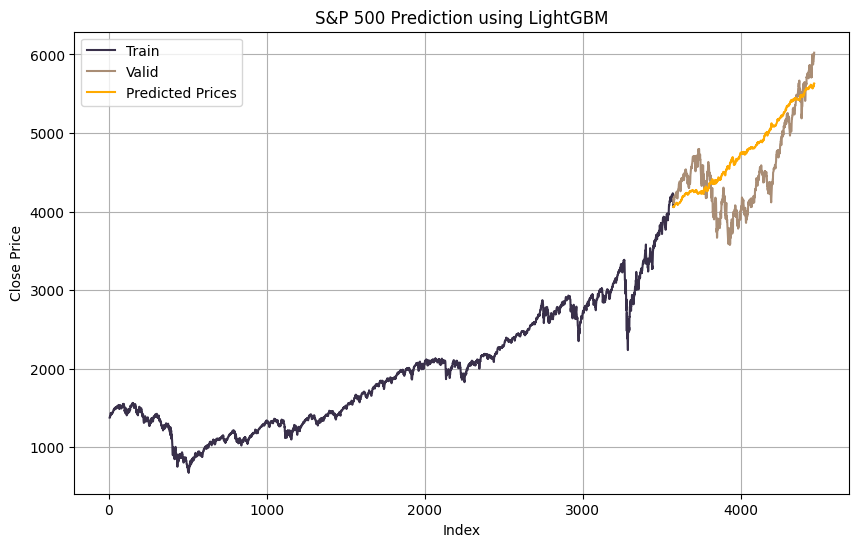

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

def prepare_data(data, h_vals, n_lags=5):
    data['Returns'] = np.log(data['Close']).diff()  # Calculate log returns
    data.dropna(inplace=True)  # Drop missing values
    
    # Add log_h values directly to the main data without merging on x_vals
    data['log_h'] = h_vals['log_h'].values[:len(data)]
    
    # Create lagged features to help model temporal relationships
    for lag in range(1, n_lags + 1):
        data[f'Returns_Lag_{lag}'] = data['Returns'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values after lagging
    
    return data[['Close', 'Returns', 'log_h'] + [f'Returns_Lag_{lag}' for lag in range(1, n_lags + 1)]]

def lightgbm_model(stock_name, data, h_vals):
    # Prepare the data
    data = prepare_data(data, h_vals)
    
    # Define features and target
    X = data.drop(columns=['Returns', 'Close'])
    y = data['Returns']

    # Split the data into training and testing sets (keeping sequential order)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Initialize and train the LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.3,
        'num_leaves': 100,
        'max_depth': -1,
        'feature_fraction': 0.9
    }
    
    model = lgb.train(params, train_set=train_data, num_boost_round=1000, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions for returns
    predicted_returns = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate RMSE for returns
    rmse = np.sqrt(np.mean((predicted_returns - y_test) ** 2))
    print(f'RMSE LightGBM (Returns): {rmse}')

    # Calculate predicted prices from predicted returns
    predicted_prices = [data['Close'].iloc[split_index - 1]]  # Start with the last known price from training data
    for ret in predicted_returns:
        predicted_prices.append(predicted_prices[-1] * np.exp(ret))
    predicted_prices = pd.Series(predicted_prices[1:], index=y_test.index)

    # Align predictions index with validation set
    train = data.iloc[:split_index]
    valid = data.iloc[split_index:]
    
    # Plot results using matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Close'], label='Train', color='#39304A')
    plt.plot(valid.index, valid['Close'], label='Valid', color='#A98D75')
    plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices', color='#FFAA00')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('S&P 500 Prediction using LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_prices, rmse

# Example usage
data = pd.read_csv('sp500.csv')
h_vals = pd.read_csv('h_vals.csv')
h_vals['log_h'] = np.log(h_vals['h_values'])
predicted_prices, rmse = lightgbm_model('S&P 500', data, h_vals)

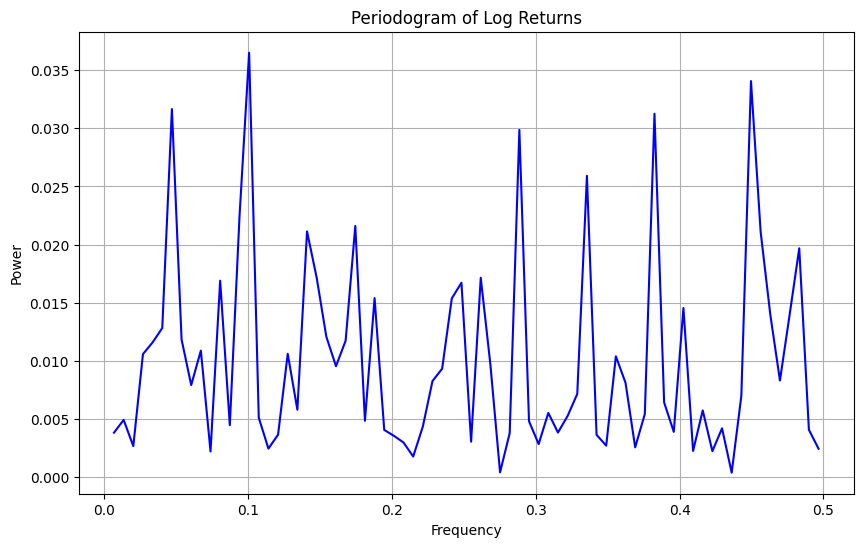

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_periodogram(data):
    """
    Plots the periodogram for the differenced Close prices (log returns) in the data.
    """
    # Calculate the Fast Fourier Transform (FFT) of the differenced Close prices
    fft_vals = np.fft.fft(data['Log_Returns'] - np.mean(data['Log_Returns']))
    fft_freqs = np.fft.fftfreq(len(data['Log_Returns']))

    # Compute the power spectrum
    power = np.abs(fft_vals) ** 2

    # Keep only the positive frequencies
    positive_freqs = fft_freqs[fft_freqs > 0]
    positive_power = power[fft_freqs > 0]

    # Plot the periodogram
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_power, color='blue')
    plt.title('Periodogram of Log Returns')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.grid(True)
    plt.show()

# Load the data
data = pd.read_csv('sp500.csv')

# Subset the data to the last 150 points
data = data.tail(150)

# Calculate log returns
data['Log_Returns'] = np.log(data['Close']).diff()

# Drop NaN values resulting from differencing
data.dropna(inplace=True)

# Proceed with the rest of the analysis
plot_periodogram(data)


## Noisy GBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3568, number of used features: 6
[LightGBM] [Info] Start training from score 0.000297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0104975
RMSE LightGBM (Returns): 0.010497521991510913


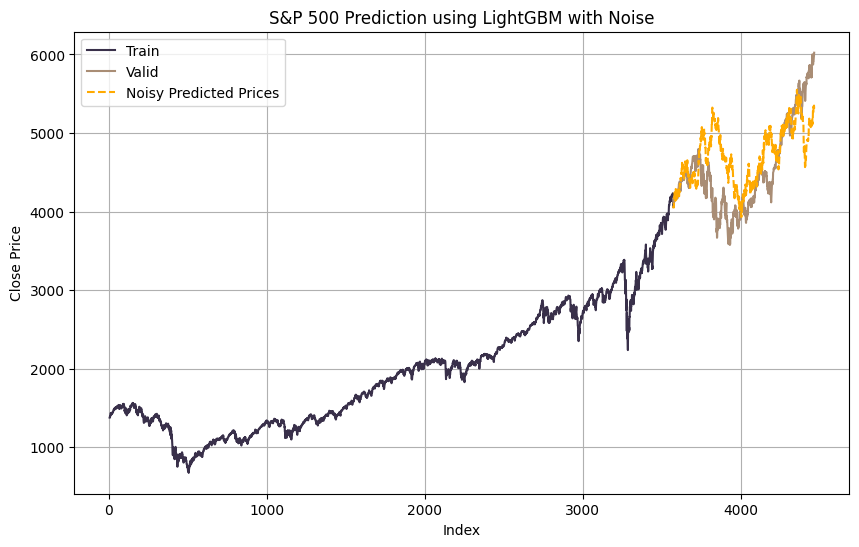

In [18]:
import random

random.seed(42)

def lightgbm_model_with_noise(stock_name, data, h_vals):
    # Prepare the data
    data = prepare_data(data, h_vals)
    
    # Define features and target
    X = data.drop(columns=['Returns', 'Close'])
    y = data['Returns']

    # Split the data into training and testing sets (keeping sequential order)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Initialize and train the LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.3,
        'num_leaves': 100,
        'max_depth': -1,
        'feature_fraction': 0.9
    }
    
    model = lgb.train(params, train_set=train_data, num_boost_round=1000, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions for returns
    predicted_returns = model.predict(X_test, num_iteration=model.best_iteration)

    # Add random noise based on dominant frequencies from the periodogram
    # For simplicity, we'll assume noise scales linearly with the power spectrum
    noise_scale = 0.01  # Adjust this value as needed
    random.seed(42)
    random_noise = np.random.normal(loc=0, scale=noise_scale, size=len(predicted_returns))
    noisy_predicted_returns = predicted_returns + random_noise

    # Calculate RMSE for returns
    rmse = np.sqrt(np.mean((predicted_returns - y_test) ** 2))
    print(f'RMSE LightGBM (Returns): {rmse}')

    # Calculate predicted prices from noisy predicted returns
    predicted_prices_noisy = [data['Close'].iloc[split_index - 1]]  # Start with the last known price from training data
    for ret in noisy_predicted_returns:
        predicted_prices_noisy.append(predicted_prices_noisy[-1] * np.exp(ret))
    predicted_prices_noisy = pd.Series(predicted_prices_noisy[1:], index=y_test.index)

    # Align predictions index with validation set
    train = data.iloc[:split_index]
    valid = data.iloc[split_index:]
    
    # Plot results using matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Close'], label='Train', color='#39304A')
    plt.plot(valid.index, valid['Close'], label='Valid', color='#A98D75')
    plt.plot(predicted_prices_noisy.index, predicted_prices_noisy, label='Noisy Predicted Prices', color='#FFAA00', linestyle='dashed')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('S&P 500 Prediction using LightGBM with Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_prices_noisy, rmse

# Example usage
random.seed(42)
data = pd.read_csv('sp500.csv')
h_vals = pd.read_csv('h_vals.csv')
h_vals['log_h'] = np.log(h_vals['h_values'])
predicted_prices_noisy, rmse = lightgbm_model_with_noise('S&P 500', data, h_vals)
